In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Cargar los datos
data = pd.read_csv('train.csv')


In [3]:
# Preprocesamiento de datos: eliminar columnas innecesarias
df = data.drop(["type", "id", "uri", "track_href", "analysis_url", "song_name", "Unnamed: 0", "title", "duration_ms", "time_signature"], axis=1)

In [4]:
# Selección de características (usamos todas las características numéricas)
X = df.loc[:, :"tempo"]

In [5]:
# Tomar una muestra representativa del 10% de los datos para hacer las pruebas más rápidas
X_sampled = X.sample(frac=0.1, random_state=42)

In [6]:
# Normalización de los datos
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_sampled)

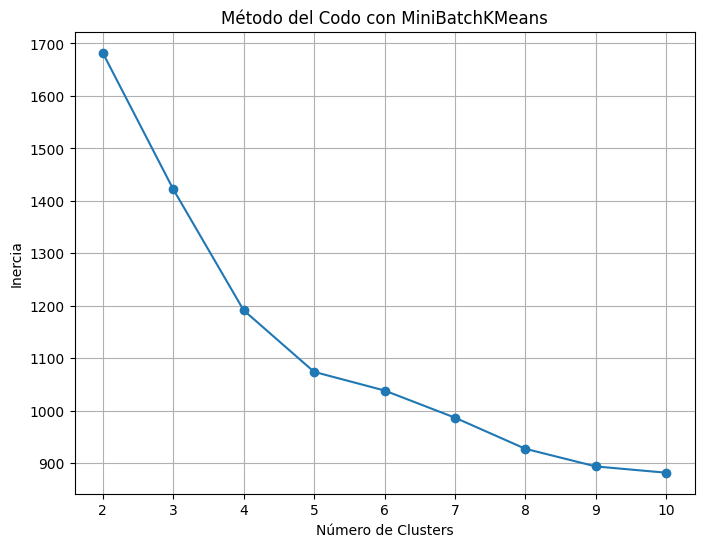

In [7]:
# Reducción de dimensionalidad con PCA (usamos 11 componentes)
pca = PCA(n_components=11)
X_pca = pca.fit_transform(X_scaled)

# Método del codo para determinar el número óptimo de clusters
inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, marker='o')
plt.title("Método del Codo con MiniBatchKMeans")
plt.xlabel("Número de Clusters")
plt.ylabel("Inercia")
plt.grid(True)
plt.show()


In [8]:
# K-Means con el número óptimo de clusters
optimal_k = 5  # Basado en el codo
kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# Evaluar el modelo K-Means
silhouette_kmeans = silhouette_score(X_pca, kmeans_labels)
davies_bouldin_kmeans = davies_bouldin_score(X_pca, kmeans_labels)

print(f"Silhouette Score MiniBatchKMeans: {silhouette_kmeans:.4f}")
print(f"Davies-Bouldin Index MiniBatchKMeans: {davies_bouldin_kmeans:.4f}")

Silhouette Score MiniBatchKMeans: 0.2692
Davies-Bouldin Index MiniBatchKMeans: 1.4627


In [9]:
# DBSCAN con ajuste de parámetros
best_silhouette_dbscan = -1
best_eps = 0.6
best_min_samples = 5
for eps in np.arange(0.4, 1.5, 0.05):  # Probar eps más pequeños
    for min_samples in range(5, 20):  # Probar un rango más grande para min_samples
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_pca)
        
        # Filtrar solo si hay más de un cluster
        if len(set(dbscan_labels)) > 1:
            silhouette_dbscan = silhouette_score(X_pca, dbscan_labels)
            if silhouette_dbscan > best_silhouette_dbscan:
                best_silhouette_dbscan = silhouette_dbscan
                best_eps = eps
                best_min_samples = min_samples

print(f"Mejor DBSCAN: eps={best_eps}, min_samples={best_min_samples}, Silhouette Score={best_silhouette_dbscan:.4f}")

# DBSCAN con los mejores parámetros encontrados
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan.fit_predict(X_pca)

# Evaluar el modelo DBSCAN
silhouette_dbscan = silhouette_score(X_pca, dbscan_labels)
davies_bouldin_dbscan = davies_bouldin_score(X_pca, dbscan_labels)

print(f"Silhouette Score DBSCAN: {silhouette_dbscan:.4f}")
print(f"Davies-Bouldin Index DBSCAN: {davies_bouldin_dbscan:.4f}")



Mejor DBSCAN: eps=0.8999999999999999, min_samples=5, Silhouette Score=0.3229
Silhouette Score DBSCAN: 0.3229
Davies-Bouldin Index DBSCAN: 1.3521


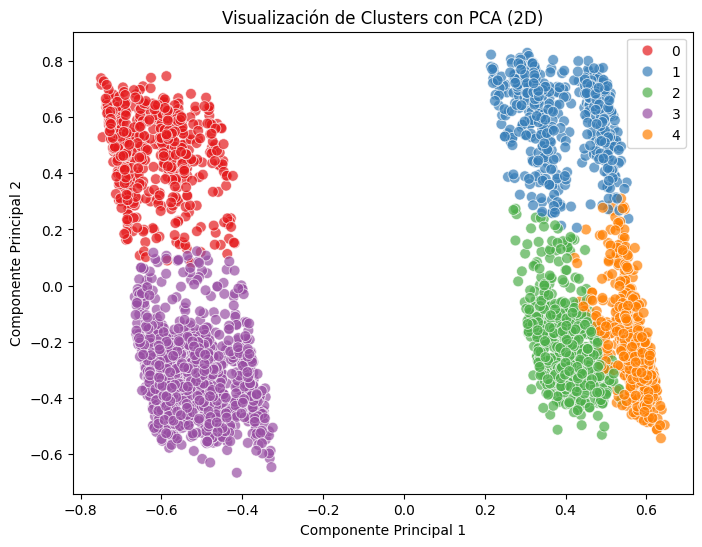

In [10]:
# Visualización de resultados con PCA en 2D
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_pca)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], hue=kmeans_labels, palette="Set1", s=60, alpha=0.7)
plt.title('Visualización de Clusters con PCA (2D)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()


Conclusión Final:

**DBSCAN** ha mostrado un rendimiento superior en términos de Silhouette Score (0.3229) y Davies-Bouldin Index (1.3521), lo que sugiere que ha logrado una mejor definición y separación de los clusters. Esto lo hace una mejor solución para este caso, especialmente si los datos tienen una estructura no esférica.

**MiniBatchKMeans**, con un Silhouette Score de 0.2692 y un Davies-Bouldin Index de 1.4627, sigue siendo una opción válida, especialmente cuando se busca eficiencia y rapidez en el procesamiento de grandes conjuntos de datos. Sin embargo, no ha mostrado una separación tan clara como DBSCAN.